In [ ]:
!pip install covidcast

import covidcast
import datetime
from datetime import date
from matplotlib import pyplot as plt
import pandas as pd
import plotnine as p9
from mizani.breaks import date_breaks
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

BOSTON = '71650' # Boston-Cambridge-Quincy, MA-NH
SEATTLE = '42660' # Seattle-Tacoma-Bellevue, WA
NEW_YORK = '35620'
TALLAHASEE = '45220'
NEW_ORLEANS = '35380' # New Orleans-Metairie-Kenner, LA
MIAMI =  '33100' # Miami-Fort Lauderdale-Miami Beach, FL
PHOENIX = '38060'

In [72]:
# GET CASES
cases = covidcast.signal(data_source = "usa-facts", 
                         signal = "confirmed_7dav_incidence_num", geo_type = 'msa',
                         start_day = date(2020, 3, 1), end_day = date.today() - datetime.timedelta(days=10))

In [73]:
# GET DOCTOR VISITS
doctor_visits = covidcast.signal(data_source = "doctor-visits", 
                                 signal = "smoothed_adj_cli", geo_type = "msa", 
                                 start_day =  date(2020, 3, 1), end_day = date.today() - datetime.timedelta(days=10))

In [74]:
# GET QUIDEL TESTS
quidel_smooth = covidcast.signal(data_source = "quidel", 
                                signal = "covid_ag_smoothed_pct_positive", geo_type = "msa",
                                start_day = date(2020, 5, 26), end_day = date.today() - datetime.timedelta(days=10))

In [75]:
# GET FB SURVEY COMMUNITY ILLNESS
cmnty_cli = covidcast.signal(data_source = "fb-survey", 
                                signal = "raw_hh_cmnty_cli", geo_type = "msa",
                                start_day = date(2020, 4, 15), end_day = date.today() - datetime.timedelta(days=10))

In [76]:
# ALL SIGNALS
signals = [doctor_visits, quidel_smooth, cmnty_cli]


In [77]:
# GET CASES IN CITIES
new_york = cases.loc[cases['geo_value'] == NEW_YORK]
# boston = cases.loc[cases['geo_value'] == BOSTON] 
seattle = cases.loc[cases['geo_value'] == SEATTLE] 
tallahasee = cases.loc[cases['geo_value'] == TALLAHASEE]
new_orleans = cases.loc[cases['geo_value'] == NEW_ORLEANS]
miami = cases.loc[cases['geo_value'] == MIAMI]
phoenix = cases.loc[cases['geo_value'] == PHOENIX]

In [78]:
# GET SIGNALS FOR CITIES
def get_signals_for_location(city, signals):
  return [signal.loc[signal['geo_value'] == city] for signal in signals]

signals_new_york = get_signals_for_location(NEW_YORK, signals)
signals_seattle = get_signals_for_location(SEATTLE, signals)
signals_tallahasee = get_signals_for_location(TALLAHASEE, signals)
signals_new_orleans = get_signals_for_location(NEW_ORLEANS, signals)
signals_miami = get_signals_for_location(MIAMI, signals)
signals_phoenix = get_signals_for_location(PHOENIX, signals)

In [79]:
# SET EVERYTHING TO T0
def get_t0(city_cases, signals):
  for i, value in enumerate(city_cases['value']):
    if value >= 100:
      t0_date = city_cases.iloc[i]['time_value']
      return t0_date, city_cases[i:], [signal.loc[signal['time_value'] >= t0_date] for signal in signals]

t0_new_york, t0_cases_new_york, t0_signals_new_york = get_t0(new_york, signals_new_york)
t0_seattle, t0_cases_seattle, t0_signals_seattle = get_t0(seattle, signals_seattle)
t0_tallahasee, t0_cases_tallahasee, t0_signals_tallahasee = get_t0(tallahasee, signals_tallahasee)
t0_new_orleans, t0_cases_new_orleans, t0_signals_new_orleans = get_t0(new_orleans, signals_new_orleans)
t0_miami, t0_cases_miami, t0_signals_miami = get_t0(miami, signals_miami)
t0_phoenix, t0_cases_phoenix, t0_signals_phoenix = get_t0(phoenix, signals_phoenix)

# **New Orleans**

New Orleans has a summer wave of cases and corresponding increases in `doctor visits` and `Quidel that do seem to be leading indicators.

In [ ]:
# CASES
(p9.ggplot(data=t0_cases_new_orleans,
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line())


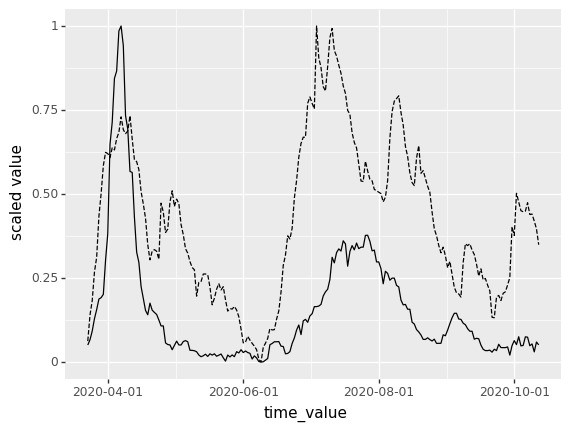

<ggplot: (-9223363304951551200)>

In [80]:
# DOCTOR VISITS
cases_doctor_new_orleans = pd.merge(t0_cases_new_orleans, t0_signals_new_orleans[0], on='time_value')
cases_doctor_new_orleans[['case_value', 'doctor_visits']] = scaler.fit_transform(cases_doctor_new_orleans[['value_x', 'value_y']])

(p9.ggplot(cases_doctor_new_orleans, p9.aes(x='time_value')) + 
p9.scale_x_datetime(breaks=date_breaks('2 months')) +
p9.geom_line(p9.aes(y='doctor_visits') , linetype='dashed') +
p9.geom_line(p9.aes(y='case_value')) + 
p9.ylab("scaled value"))


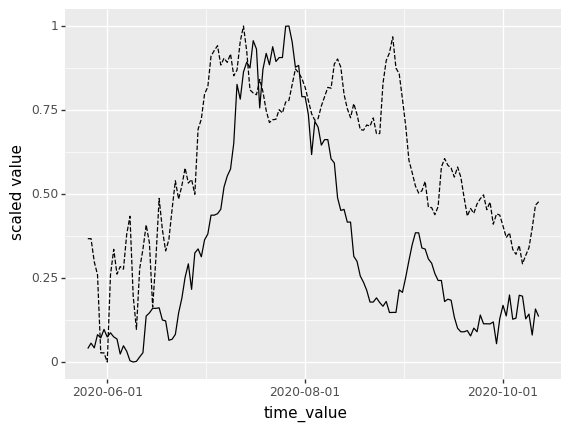

<ggplot: (-9223363304951554223)>

In [81]:
# QUIDEL
cases_quidel_new_orleans = pd.merge(t0_cases_new_orleans, t0_signals_new_orleans[1], on='time_value')
cases_quidel_new_orleans[['case_value', 'quidel_tests']] = scaler.fit_transform(cases_quidel_new_orleans[['value_x', 'value_y']])

(p9.ggplot(cases_quidel_new_orleans, p9.aes(x='time_value')) + 
p9.scale_x_datetime(breaks=date_breaks('2 months')) +
p9.geom_line(p9.aes(y='quidel_tests') , linetype='dashed') +
p9.geom_line(p9.aes(y='case_value')) + 
p9.ylab("scaled value"))



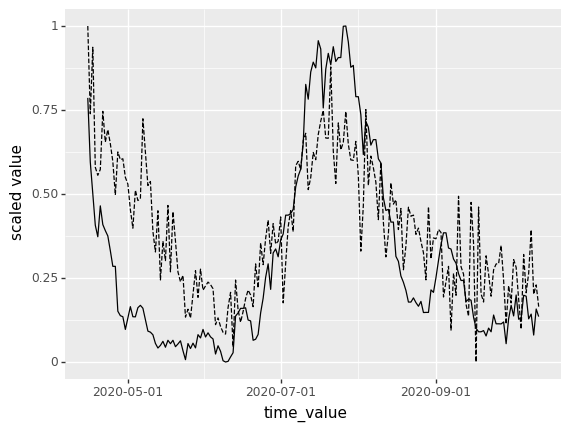

<ggplot: (-9223363304962770993)>

In [82]:
# FB SURVEY
cases_fb_new_orleans = pd.merge(t0_cases_new_orleans, t0_signals_new_orleans[2], on='time_value')
cases_fb_new_orleans[['case_value', 'fb_survey']] = scaler.fit_transform(cases_fb_new_orleans[['value_x', 'value_y']])

(p9.ggplot(cases_fb_new_orleans, p9.aes(x='time_value')) + 
p9.scale_x_datetime(breaks=date_breaks('2 months')) +
p9.geom_line(p9.aes(y='fb_survey') , linetype='dashed') +
p9.geom_line(p9.aes(y='case_value')) + 
p9.ylab("scaled value"))




# **Miami**

Miami looks similar to New Orleans, with the `doctor visits` and `Quidel` leading the cases by a bit, but not by as much as in New Orleans it seems. `Quidel` has a spike right before the cases increase, but it goes back down, which might mean it is just noise. Like New Orleans, the `fb cmnty cli` signals seems to adhere tightly to the curve of the cases.


In [ ]:
# CASES
(p9.ggplot(data=t0_cases_miami,
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line())

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


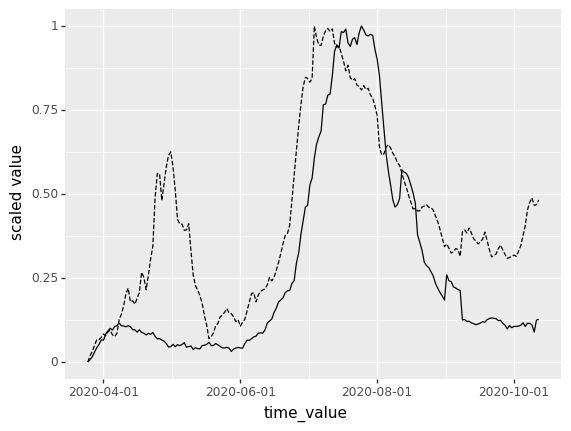

<ggplot: (-9223363304951525923)>

In [83]:
# DOCTOR VISITS
cases_doctor_miami = pd.merge(t0_cases_miami, t0_signals_miami[0], on='time_value')
cases_doctor_miami[['case_value', 'doctor_visits']] = scaler.fit_transform(cases_doctor_miami[['value_x', 'value_y']])

(p9.ggplot(cases_doctor_miami, p9.aes(x='time_value', show_legend=True)) + 
p9.scale_x_datetime(breaks=date_breaks('2 months')) +
p9.geom_line(p9.aes(y='doctor_visits') , linetype='dashed', show_legend=True) +
p9.geom_line(p9.aes(y='case_value'),  show_legend=True) + 
p9.ylab("scaled value"))


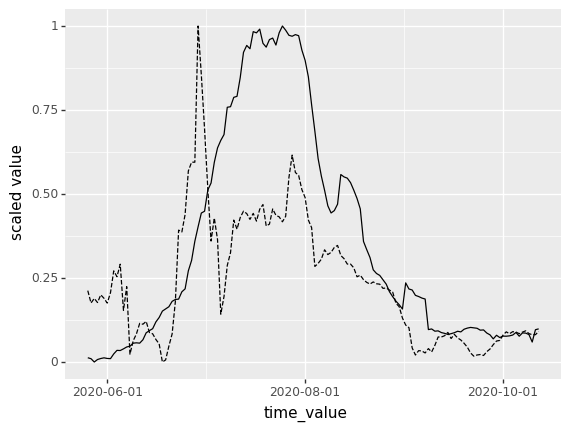

<ggplot: (8731903249861)>

In [84]:
# QUIDEL
cases_quidel_miami = pd.merge(t0_cases_miami, t0_signals_miami[1], on='time_value')
cases_quidel_miami[['case_value', 'quidel_tests']] = scaler.fit_transform(cases_quidel_miami[['value_x', 'value_y']])

(p9.ggplot(cases_quidel_miami, p9.aes(x='time_value')) + 
p9.scale_x_datetime(breaks=date_breaks('2 months')) +
p9.geom_line(p9.aes(y='quidel_tests') , linetype='dashed') +
p9.geom_line(p9.aes(y='case_value')) + 
p9.ylab("scaled value"))

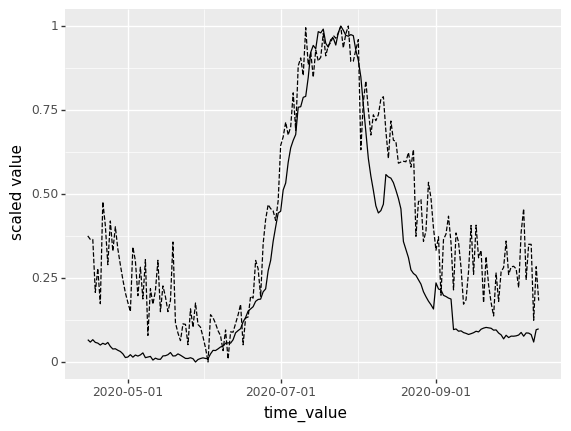

<ggplot: (8731903281335)>

In [85]:
# FB SURVEY
cases_fb_miami = pd.merge(t0_cases_miami, t0_signals_miami[2], on='time_value')
cases_fb_miami[['case_value', 'fb_survey']] = scaler.fit_transform(cases_fb_miami[['value_x', 'value_y']])

(p9.ggplot(cases_fb_miami, p9.aes(x='time_value')) + 
p9.scale_x_datetime(breaks=date_breaks('2 months')) +
p9.geom_line(p9.aes(y='fb_survey') , linetype='dashed') +
p9.geom_line(p9.aes(y='case_value')) + 
p9.ylab("scaled value"))

# **Phoenix**

Quidel is not very helpful for Phoenix here, as it starts after the cases start increasing.

`Doctor visits` and `fb cmnty cli` seem to adhere tightly to the case curve.

In [ ]:
# CASES
(p9.ggplot(data=t0_cases_phoenix,
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line())

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


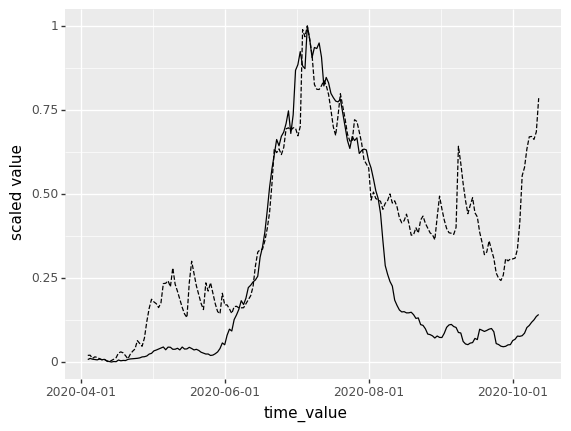

<ggplot: (8731903284793)>

In [86]:
# DOCTOR VISITS
cases_doctor_phoenix = pd.merge(t0_cases_phoenix, t0_signals_phoenix[0], on='time_value')
cases_doctor_phoenix[['case_value', 'doctor_visits']] = scaler.fit_transform(cases_doctor_phoenix[['value_x', 'value_y']])

(p9.ggplot(cases_doctor_phoenix, p9.aes(x='time_value', show_legend=True)) + 
p9.scale_x_datetime(breaks=date_breaks('2 months')) +
p9.geom_line(p9.aes(y='doctor_visits') , linetype='dashed', show_legend=True) +
p9.geom_line(p9.aes(y='case_value'),  show_legend=True) + 
p9.ylab("scaled value"))

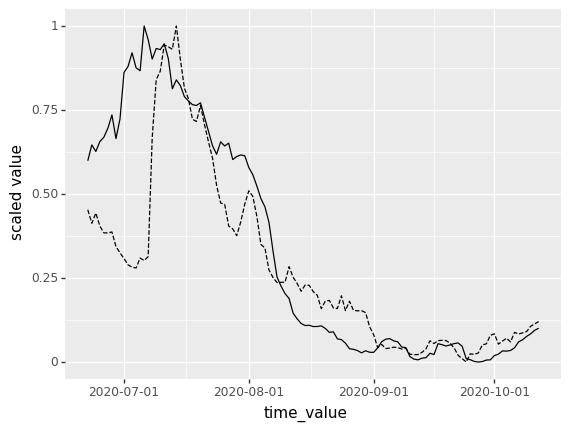

<ggplot: (-9223363304951486909)>

In [87]:
#QUIDEL
cases_quidel_phoenix = pd.merge(t0_cases_phoenix, t0_signals_phoenix[1], on='time_value')
cases_quidel_phoenix[['case_value', 'quidel_tests']] = scaler.fit_transform(cases_quidel_phoenix[['value_x', 'value_y']])

(p9.ggplot(cases_quidel_phoenix, p9.aes(x='time_value')) + 
p9.scale_x_datetime(breaks=date_breaks('1 month')) +
p9.geom_line(p9.aes(y='quidel_tests') , linetype='dashed') +
p9.geom_line(p9.aes(y='case_value')) + 
p9.ylab("scaled value"))

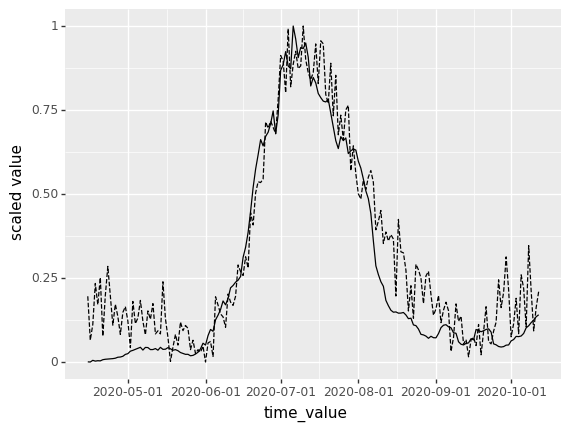

<ggplot: (-9223363304951547644)>

In [88]:
# FB SURVEY
cases_fb_phoenix = pd.merge(t0_cases_phoenix, t0_signals_phoenix[2], on='time_value')
cases_fb_phoenix[['case_value', 'fb_survey']] = scaler.fit_transform(cases_fb_phoenix[['value_x', 'value_y']])

(p9.ggplot(cases_fb_phoenix, p9.aes(x='time_value')) + 
p9.scale_x_datetime(breaks=date_breaks('1 month')) +
p9.geom_line(p9.aes(y='fb_survey') , linetype='dashed') +
p9.geom_line(p9.aes(y='case_value')) + 
p9.ylab("scaled value"))


## METRO AREAS BELOW HERE ARE NOT VERY HELPFUL



# **Tallahasee**

This city's first day with over 100 cases was later, on 6/28, so it is a better match for using the Quidel and FB Survey data. However, it dips below 100 many times after that, and has an overall low case count. We need to find cities that have a higher number of cases and a wave of infection that starts after May to be able to look at all these signals.

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


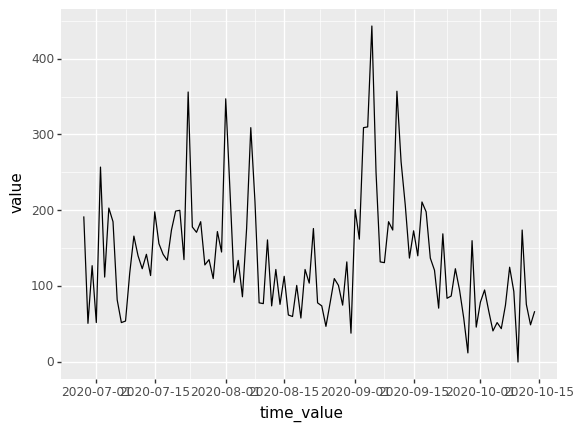

<ggplot: (8729260204040)>

In [ ]:
(p9.ggplot(data=t0_cases_tallahasee,
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line())


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


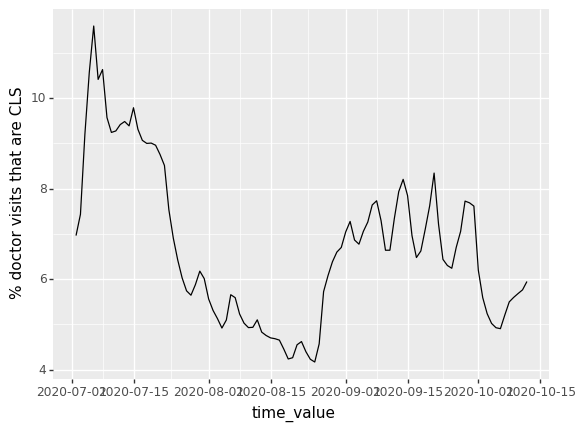

<ggplot: (8731903223416)>

In [89]:
(p9.ggplot(data=t0_signals_tallahasee[0],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line()
           + p9.ylab("% doctor visits that are CLS") + p9.aes(xmin=t0_tallahasee))


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


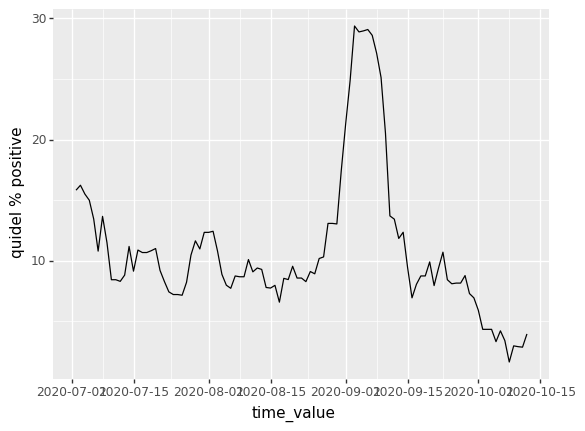

<ggplot: (-9223363304951486818)>

In [90]:
(p9.ggplot(data=t0_signals_tallahasee[1],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line() 
           + p9.ylab("quidel % positive") + p9.aes(xmin=t0_tallahasee))


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


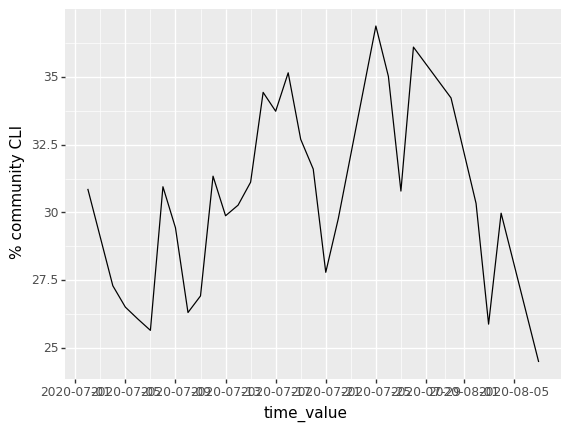

<ggplot: (8731903266410)>

In [91]:
(p9.ggplot(data=t0_signals_tallahasee[2],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line() 
           + p9.ylab("% community CLI") + p9.aes(xmin=t0_tallahasee))


# **New York**

Starting off with New York since it had a huge, well defined wave of infection.

Since New York had such an early outbreak, it's hard to compare the Quidel and Facebook signals to the spike the cases because we don't have any data from these signals before the biggest outbreak started in New York. 

New York cases are starting to rise, so these signals might become better indicators in New York in the near future.

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


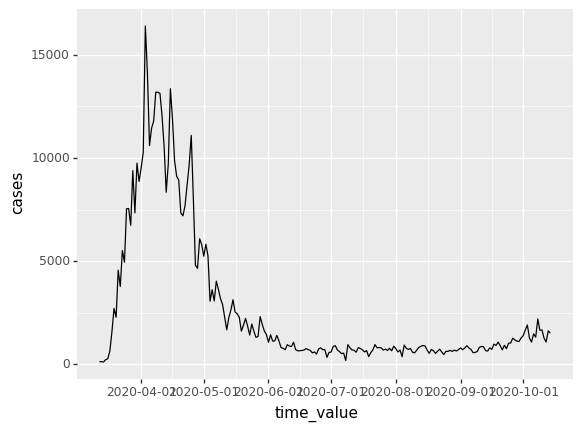

<ggplot: (8729221790973)>

In [ ]:
# CASES NEW YORK

(p9.ggplot(data=t0_cases_new_york,
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line() + p9.ylab("cases"))

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


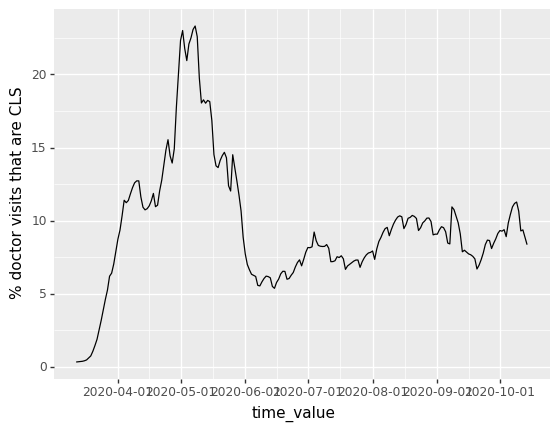

<ggplot: (-9223363307620553286)>

In [ ]:
# DOCTOR VISITS NEW YORK
(p9.ggplot(data=t0_signals_new_york[0],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line() 
           + p9.ylab("% doctor visits that are CLS") + p9.aes(xmin=t0_new_york))


In [ ]:
# QUIDEL NEW YORK
(p9.ggplot(data=t0_signals_new_york[1],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line()
           + p9.ylab("quidel % positive") + p9.aes(xmin=t0_new_york))


**Note**

The smoothed Quidel signal starts on 6/02 with a value of ~5%, while the raw signal starts later on 6/17.

In [ ]:
# COMMUNITY CLI NEW YORK
(p9.ggplot(data=t0_signals_new_york[2],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line() 
           + p9.ylab("% community CLI") + p9.aes(xmin=t0_new_york))


# **Seattle**

Seattle has the same problem as New York for it's first outbreak - it's cases started too early for the Quidel and fb survey signals. It has a second outbreak, that we can compare though.

`Doctor visits` does not seem to be leading cases by that much. `Quidel` tests have some odd data going just before the second outbreak hits (huge spike in positive test results on a few days, then returning to low values). `Fb cmnty cli` does not seem to lead the cases by much.

In [ ]:
# CASES SEATTLE

(p9.ggplot(data=t0_cases_seattle,
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line())



In [ ]:
# DOCTOR VISITS SEATTLE

(p9.ggplot(data=t0_signals_seattle[0],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line()
           + p9.ylab("% doctor visits that are CLS") + p9.aes(xmin=t0_seattle))


In [ ]:
# QUIDEL SEATTLE

(p9.ggplot(data=t0_signals_seattle[1],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line()
           + p9.ylab("quidel % positive") + p9.aes(xmin=t0_seattle))


In [ ]:
# COMMUNITY CLI SEATTLE

(p9.ggplot(data=t0_signals_seattle[2],
           mapping=p9.aes(x='time_value', y='value')) + p9.geom_line()
           + p9.ylab("% community CLI") + p9.aes(xmin=t0_seattle))
